In [1]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

class ArtLoader:
    """Load in art from artists as an array, batched and ready for tf"""
    
    def __init__(self, data_path):
        """set the path to the data directory"""
        # remove slash if it exists, accounted for in code below
        if data_path[-1] == '/':
            data_path = data_path[:-1]
        self.data_path = data_path

    def get_ponds(self, artist_name):
        """read in images from the prompt 
        'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [img_to_array(load_img(f'{self.data_path}/{artist_name}/{img_path}')) 
                         for img_path in all_img_paths  
                         if img_path[-5] in ['1', '2', '3']]
        return np.array(pond_img_list)
    
    def get_buildings(self, artist_name):
        """read in images from the prompt 
        'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'
        for a particluar artist"""
        all_img_paths = os.listdir(f'{self.data_path}/{artist_name}')
        pond_img_list = [img_to_array(load_img(f'{self.data_path}/{artist_name}/{img_path}')) 
                         for img_path in all_img_paths  
                         if img_path[-5] in ['4', '5', '6']]
        return np.array(pond_img_list)

#def get_buildings(artist_path):

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

#tf.keras.applications.resnet50.preprocess_input


topless_resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='max' #avg, max
)

model = Sequential([
    Resizing(224, 224),
    topless_resnet
])

2022-04-29 22:07:33.485948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
art_loader = ArtLoader(data_path = '../raw_data/batch 1')

In [40]:
data_path = '../raw_data/batch 1'
exclude = ['non-visual artist single images','styles single images', '.DS_Store']

all_artists = [artist for artist in os.listdir(data_path) if artist not in exclude]
len(all_artists)

143

In [46]:
#'Robert_Hubert'
from tqdm import tqdm

artist_features_list = []
ponds_list = []
artist_list = []

for artist in tqdm(all_artists[:]):
    
    artist_ponds = art_loader.get_ponds(artist)

    artist_features = model(artist_ponds).numpy()#.mean(axis = 0)

    for features, pond in zip(artist_features, artist_ponds):
        artist_features_list.append(features)
        ponds_list.append(pond)
        artist_list.append(artist)

100%|█████████████████████████████████████████| 143/143 [03:14<00:00,  1.36s/it]


In [81]:
# import tensorflow_transform as tft
# import tensorflow as tf
# results = tft.pca(test_features, 2, tf.float32)

In [73]:
from sklearn.decomposition import PCA
num_pcs = 5
pca = PCA(num_pcs)
pcs = pca.fit_transform(np.array(artist_features_list))

pcs_dict = {f'pc{i+1}': pcs[:, i] for i in range(num_pcs)}
pcs_dict['artist'] = artist_list

pcs_df = pd.DataFrame(pcs_dict)

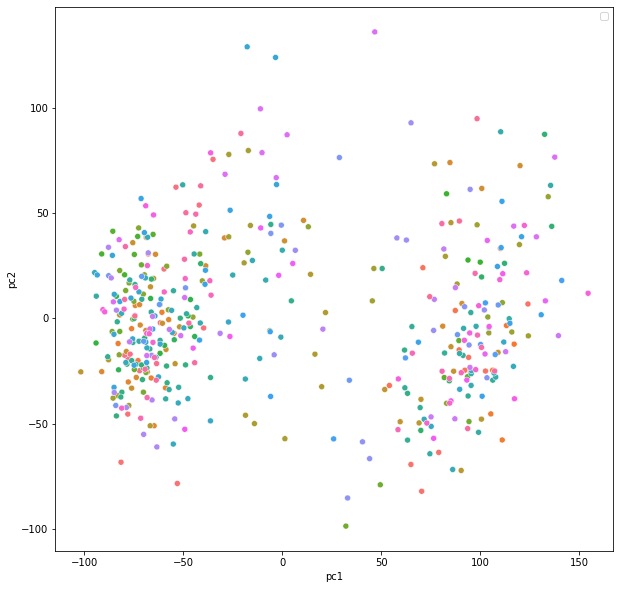

In [74]:
import seaborn as sns
fig , ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(data = pcs_df, x = 'pc1', y = 'pc2', hue = 'artist', ax = ax)
plt.legend('')

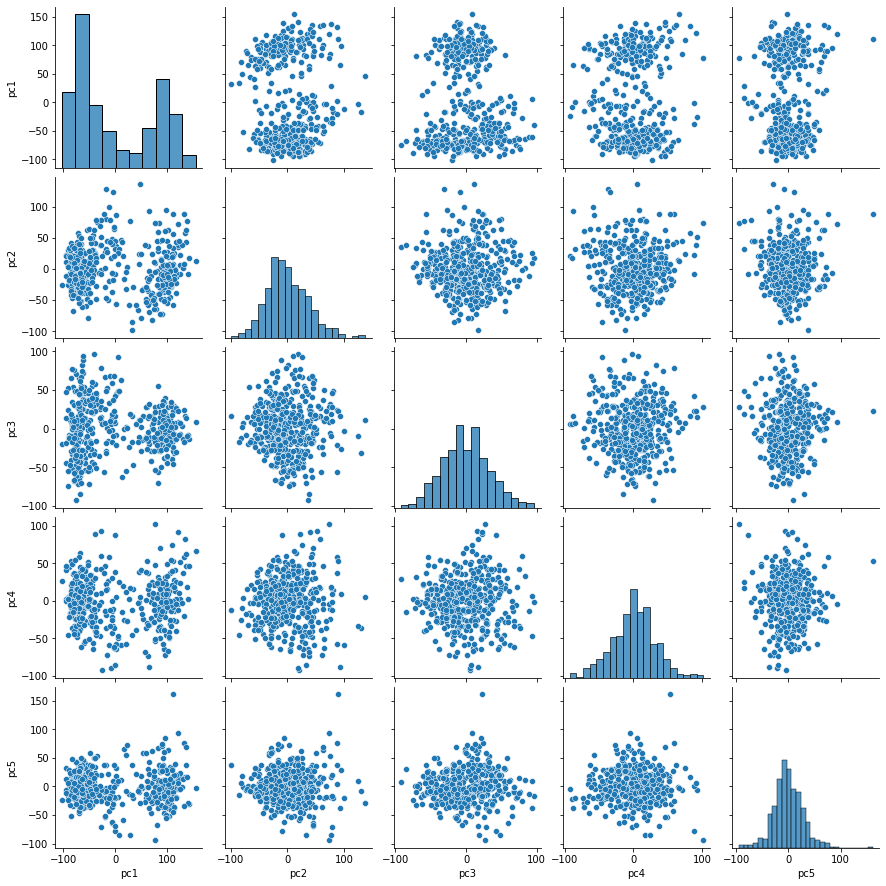

In [54]:
#sns.pairplot(data = pcs_df)

In [ ]:
## kmeans

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

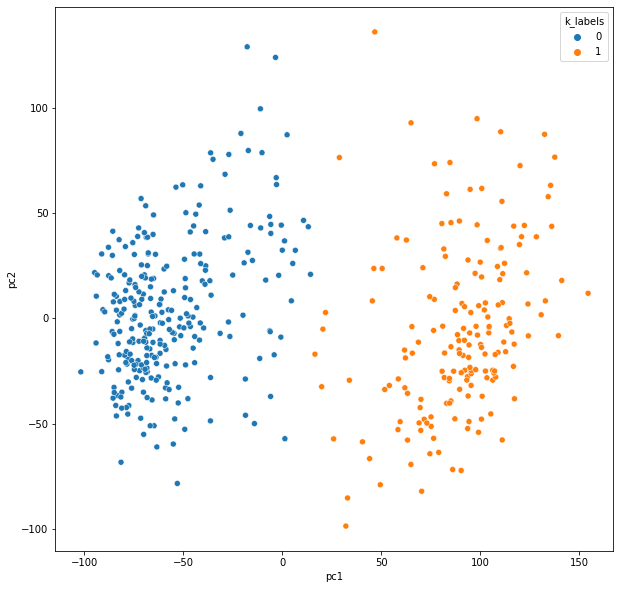

In [84]:
from sklearn.cluster import KMeans
k_cluster = KMeans(2)
k_cluster.fit(pcs)
pcs_df['k_labels'] = k_cluster.labels_

ponds = pcs_df['k_labels'] == 0

fig , ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(data = pcs_df, x = 'pc1', y = 'pc2', hue = 'k_labels', ax = ax)
#plt.legend('')

In [140]:
# pca only ponds
from sklearn.decomposition import PCA
num_pcs = 10
pca = PCA(num_pcs)
pcs_ponds = pca.fit_transform(np.array(artist_features_list)[ponds])

pcs_ponds_dict = {f'pc{i+1}': pcs_ponds[:, i] for i in range(num_pcs)}
pcs_ponds_dict['artist'] = np.array(artist_list)[ponds]

pcs_ponds_df = pd.DataFrame(pcs_ponds_dict)

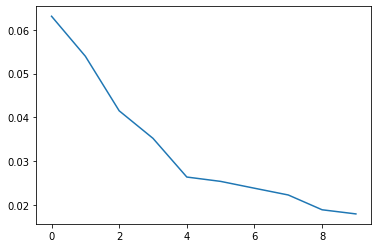

In [142]:
plt.plot(pca.explained_variance_ratio_)

In [128]:
# tsne only ponds
from sklearn.manifold import TSNE

import pandas as pd
num_tsne = 2
tsne = TSNE(num_tsne, perplexity = 7.0)
tsne_ponds = tsne.fit_transform(np.array(artist_features_list)[ponds])

tsne_ponds_dict = {f'pc{i+1}': tsne_ponds[:, i] for i in range(num_tsne)}
tsne_ponds_dict['artist'] = np.array(artist_list)[ponds]

tsne_ponds_df = pd.DataFrame(tsne_ponds_dict)

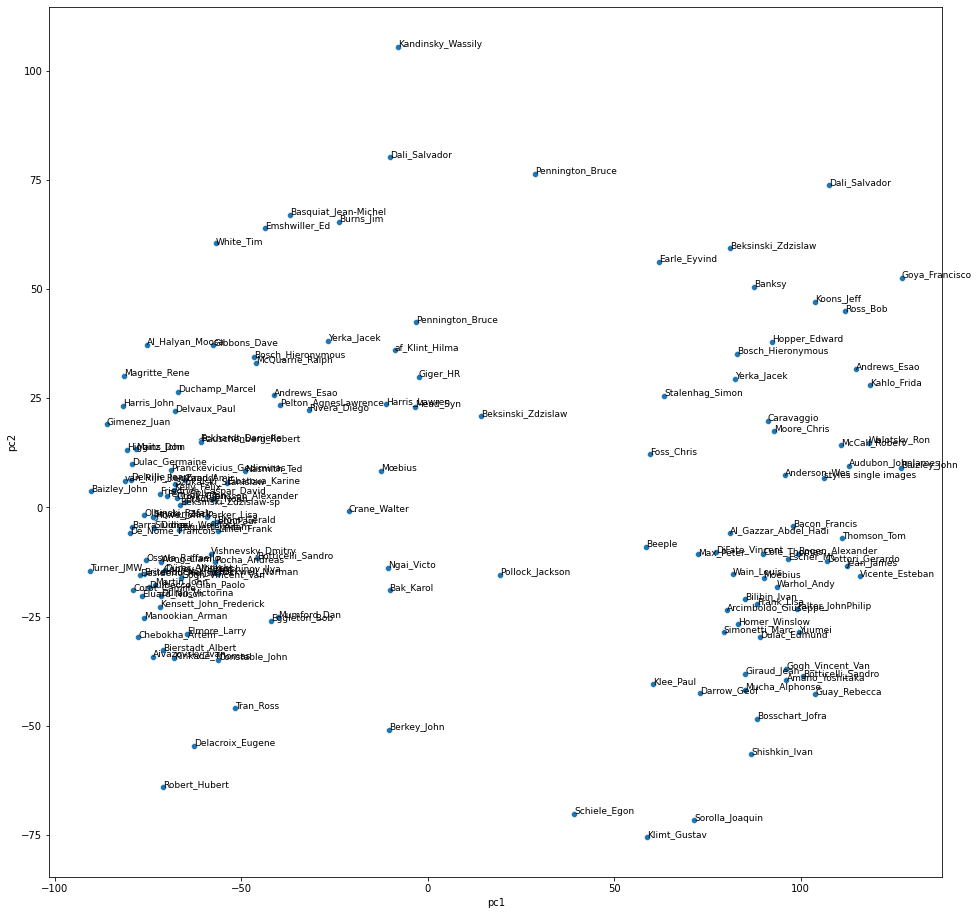

In [137]:
# create labelled scatterplot
artist_df = pcs_df.groupby(['k_labels','artist']).mean().reset_index()

fig , ax = plt.subplots(figsize = (16, 16))
sns.scatterplot(data = artist_df, x = 'pc1', y = 'pc2', ax = ax)

for i, point in artist_df.iterrows():
        ax.text(point['pc1']+.02, point['pc2'], str(point['artist']), size = '9')

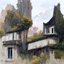

In [87]:
#from tensorflow.keras.utils import array_to_img
#array_to_img(ponds_list[0]).resize((64, 64))

In [107]:
pcs_df[ponds]
np.array(ponds_list, dtype=object)[ponds][274].shape

(1024, 1280, 3)

## plotting images onto pc coords

In [127]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize

def show_xy_images(in_df, imgs, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for idx, c_row in tqdm(in_df.reset_index().iterrows()):
        #c_img = Image.open(c_row['path']).resize((64, 64))
        c_img = resize(imgs[(idx)], [50,50]) / 255.0
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['pc1'], c_row['pc2']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['pc1', 'pc2']])
    ax1.autoscale()
    ax1.axis('off')
#show_xy_images(pcs_df[ponds], imgs = np.array(ponds_list, dtype=object)[ponds])

275it [00:04, 63.82it/s]


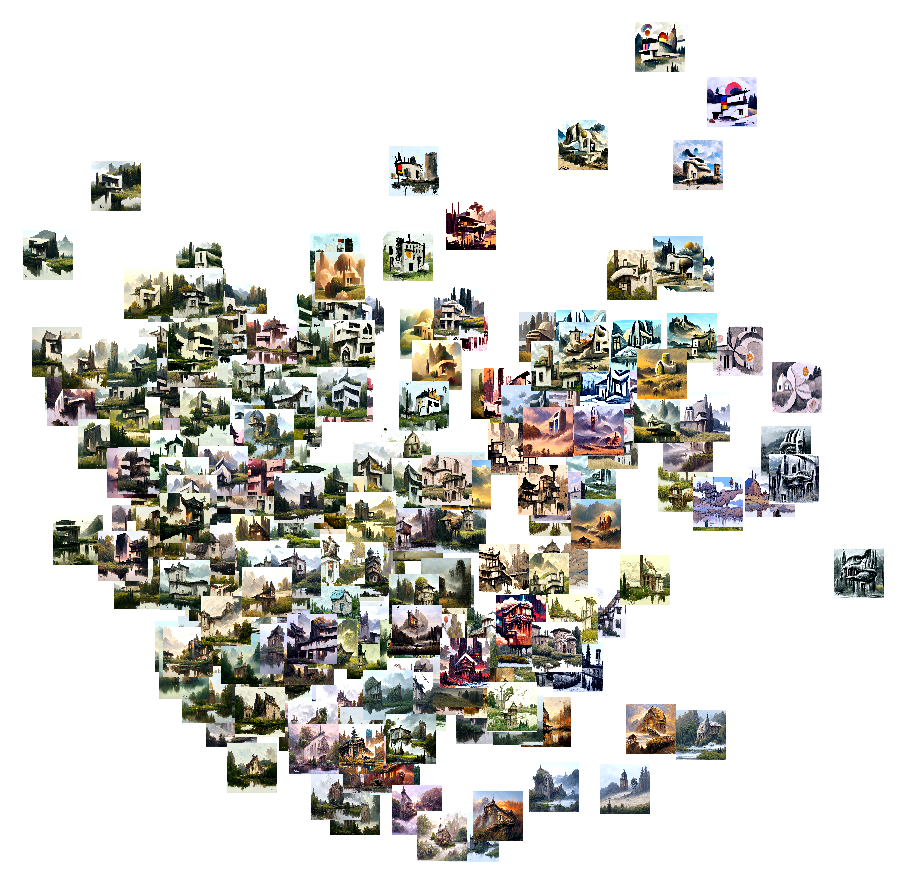

In [138]:
show_xy_images(pcs_ponds_df, imgs = np.array(ponds_list, dtype=object)[ponds])

275it [00:19, 13.94it/s]


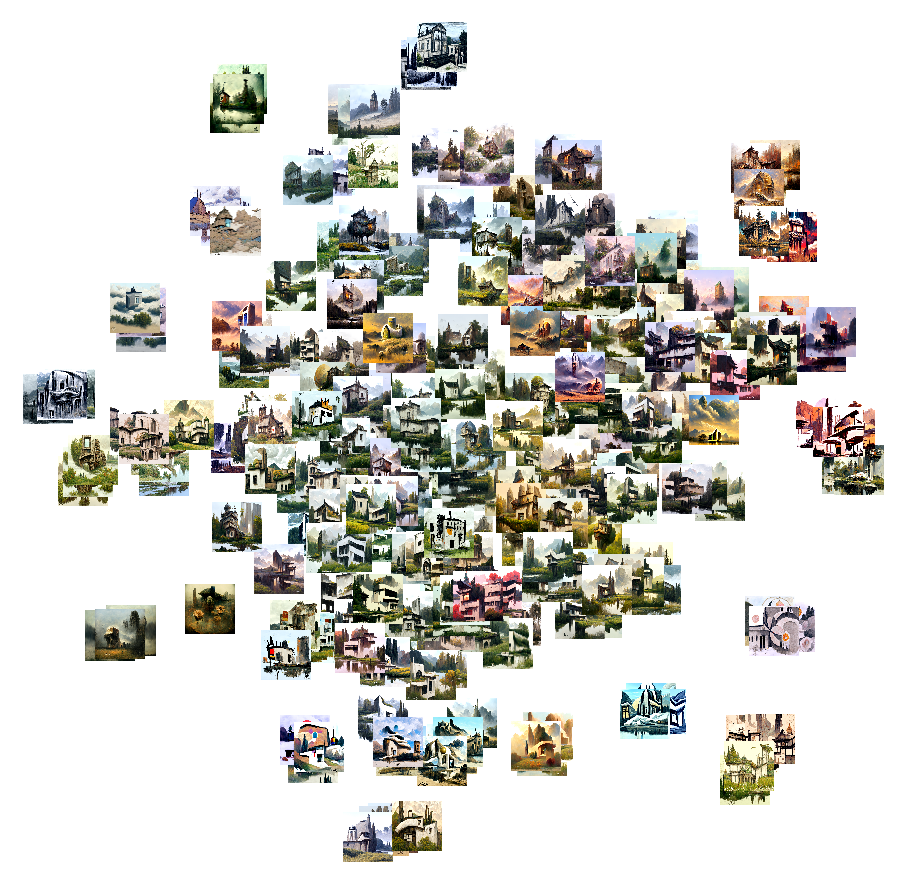

In [129]:
show_xy_images(tsne_ponds_df, imgs = np.array(ponds_list, dtype=object)[ponds])

/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_38781/3539781581.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.imshow(np.array(ponds_list)[0].astype(int))


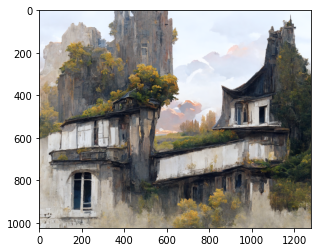

In [33]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ponds_list)[0].astype(int))

In [16]:
# resize
# get features

In [ ]:
# just add pil images to a list, have a later funtion to convert them all to an array

In [ ]:
# preprocess data properly

In [ ]:
# prompts
artist = ""
pond = f'A beautiful painting of a waterlily pond, {artist}, Trending on artstation'
building = f'A beautiful painting of a building in a serene landscape, {artist}, Trending on artstation'

In [89]:
# idea for showing the images
# https://www.kaggle.com/code/kmader/hurricane-damage-overview